## Tester for Capstone Project

#### Read config

In [ ]:
# import necessary configurations
import configparser

config = configparser.ConfigParser()
config.read_file(open('dwh.cfg'))

# amazon aws
KEY = config.get('AWS', 'key')
SECRET = config.get('AWS', 'secret')

# Redshift
DWH_DB = config.get('DWH', 'DWH_DB')
DWH_DB_USER = config.get('DWH', 'DWH_DB_USER')
DWH_DB_PASSWORD = config.get('DWH', 'DWH_DB_PASSWORD')
DWH_PORT = config.get('DWH', 'DWH_PORT')
DWH_CLUSTER_TYPE = config.get('DWH', 'DWH_CLUSTER_TYPE')
DWH_NUM_NODES = config.get('DWH', 'DWH_NUM_NODES')
DWH_NODE_TYPE = config.get('DWH', 'DWH_NODE_TYPE')
DWH_IAM_ROLE_NAME = config.get('DWH', 'DWH_IAM_ROLE_NAME')
DWH_CLUSTER_IDENTIFIER = config.get('DWH', 'DWH_CLUSTER_IDENTIFIER')
DWH_SCHEMA = config.get('DWH', 'DWH_SCHEMA')
DWH_LOG_STAGING_TABLE = config.get('DWH', 'DWH_LOG_STAGING_TABLE')
DWH_SONG_STAGING_TABLE = config.get('DWH', 'DWH_SONG_STAGING_TABLE')
DWH_REGION = config.get('DWH', 'DWH_REGION')

# s3
LOG_JSON_FORMAT = config.get('S3', 'LOG_JSON_FORMAT')
S3_BUCKET_LOG_JSON_PATH = config.get('S3', 'S3_BUCKET_LOG_JSON_PATH')
S3_BUCKET_SONG_JSON_PATH = config.get('S3', 'S3_BUCKET_SONG_JSON_PATH')

### Way 1

#### Create SQL Connection String

In [ ]:
# optional if you don't have it
!pip install ipython-sql

In [ ]:
# optional if you don't have it
!pip install psycopg2

In [3]:
%load_ext sql

In [ ]:
# save your DWH_ENDPOINT here:
DWH_ROLE_ARN = '<fill_it_up_here>'
DWH_ENDPOINT = '<fill_it_up_here>'

In [ ]:
# creating connection to your DB in Amazon Redshift
conn_string="postgresql://{}:{}@{}:{}/{}".format(DWH_DB_USER, DWH_DB_PASSWORD, DWH_ENDPOINT, DWH_PORT, DWH_DB)
%sql $conn_string

#### Get result from query

In [ ]:
%%sql
SELECT top 10 b.country_name, COUNT(cicid)
FROM project.immigration a INNER JOIN project.i94res b ON a.i94res=b.country_code
GROUP BY b.country_name
ORDER BY COUNT(cicid) DESC

### Way 2

In [ ]:
# optional: if you don't have it
!pip install pandas-redshift

#### Connection

In [27]:
import pandas_redshift as pr
pr.connect_to_redshift(dbname = 'udacity',
                        host = '<redshift_host_point>',
                        port = 5439,
                        user = '<username>',
                        password = '<password>')
import matplotlib.pyplot as plt

#### Data

In [52]:
# number of people coming from different countries
query = """
SELECT top 10 SUBSTRING(b.country_name, 0, 15) as country_name, COUNT(cicid) as count
FROM project.immigration a INNER JOIN project.i94res b ON a.i94res=b.country_code
GROUP BY b.country_name
ORDER BY COUNT(cicid) DESC
"""
df = pr.redshift_to_pandas(query)
df

,country_name,count
0,United Kingdom,3884826
1,Japan,2599102
2,France,1989185
3,Mexico Air Sea,1837594
4,"China, Prc",1813680
5,Germany,1669459
6,Brazil,1448612
7,South Korea,1330302
8,India,1148400
9,Australia,1130855


### Plot

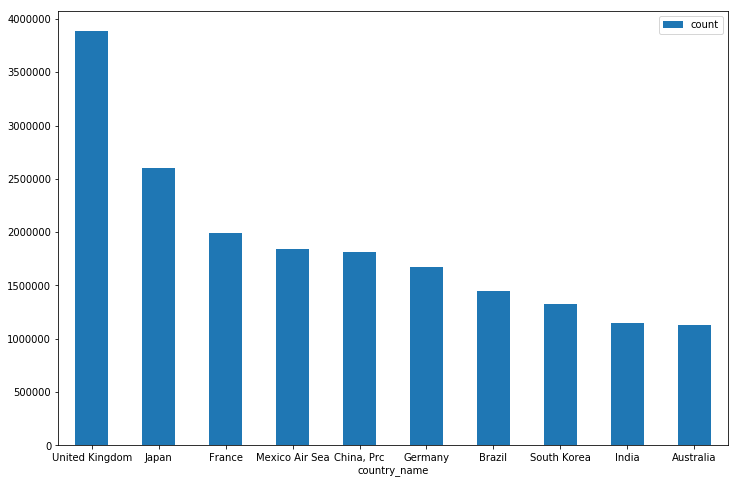

In [53]:
df.plot.bar(x='country_name', y='count', figsize=(12,8), rot=0)
plt.show()

#### Query

In [56]:
# number of small airports in different states
query = """
SELECT a.state_name AS State, airports.count AS Count_of_Airports
FROM
    (SELECT top 10 distinct substring(iso_region, 4, length(iso_region)) AS state, count(*)
     FROM project.airport_codes
     WHERE iso_country = 'US' AND type='small_airport'
     GROUP BY iso_region) airports INNER JOIN project.i94addr a ON airports.state=a.state_code
ORDER BY airports.count DESC
"""
df = pr.redshift_to_pandas(query)
df

,state,count_of_airports
0,Alaska,499
1,California,486
2,Ohio,475
3,Florida,474
4,Kansas,360
5,Nebraska,247
6,Montana,240
7,Idaho,230
8,Arizona,200
9,W. Virginia,72


#### Plot

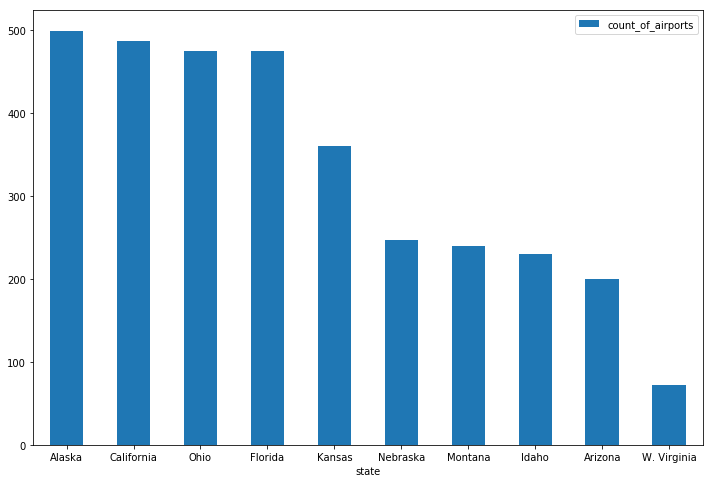

In [58]:
df.plot.bar(x='state', y='count_of_airports', figsize=(12,8), rot=0)
plt.show()

#### Query

In [59]:
# different kinds of airports in US
query = """
SELECT top 10 distinct type, count(*) AS count_type
FROM project.airport_codes
WHERE iso_country = 'US'
GROUP BY type
ORDER BY count_type DESC
"""
df = pr.redshift_to_pandas(query)
df

,type,count_type
0,small_airport,13708
1,heliport,6268
2,closed,1392
3,medium_airport,687
4,seaplane_base,566
5,large_airport,171
6,balloonport,18


#### Plot

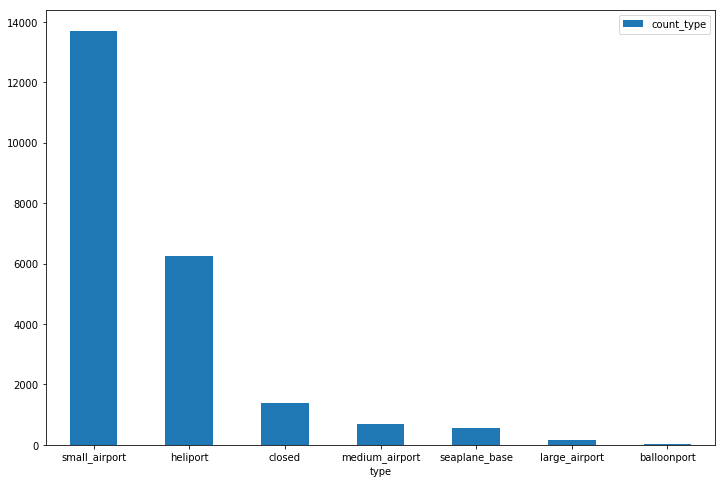

In [60]:
df.plot.bar(x='type', y='count_type', figsize=(12,8), rot=0)
plt.show()

#### Query

In [64]:
# port city from where people arrived
query = """
SELECT TOP 10 b.port_city, b.port_state_or_country, COUNT(cicid) AS count
FROM project.immigration a INNER JOIN project.i94ports b ON a.i94port=b.port_code
GROUP BY b.port_city, b.port_state_or_country
ORDER BY COUNT(cicid) DESC
"""
df = pr.redshift_to_pandas(query)
df

,port_city,port_state_or_country,count
0,New York,NY,5223986
1,Miami,FL,3623235
2,Los Angeles,CA,3214673
3,San Francisco,CA,1635007
4,Orlando,FL,1591623
5,Honolulu,HI,1508100
6,Newark/Teterboro,NJ,1467136
7,Chicago,IL,1387529
8,Houston,TX,1053096
9,Fort Lauderdale,FL,1009316


#### Plot

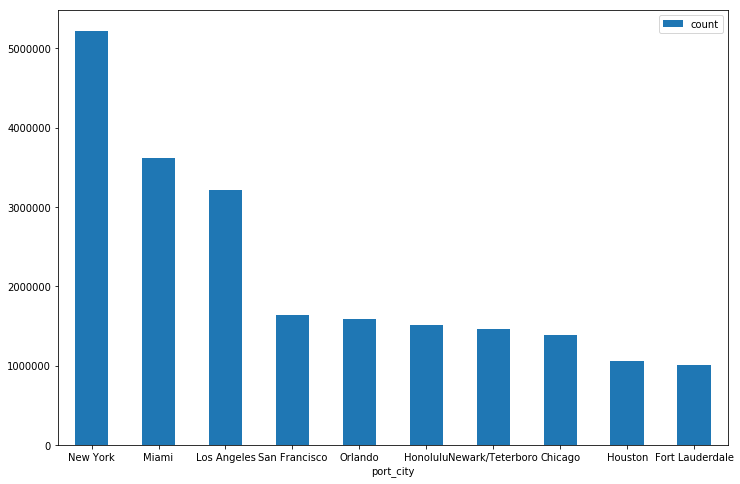

In [65]:
df.plot.bar(x='port_city', y='count', figsize=(12,8), rot=0)
plt.show()